In [1]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import zscore
from pathlib import Path
import yaml 
import os

from helpers.linkage import *
from helpers import dataloader
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
from helpers import style as style

# Set Plot Style
style.load_style()

# Load Config
cf = yaml.safe_load(Path('config.yml').read_text())

/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_types = [('lda','speech'),('lda','day')]

In [3]:
for c,(model_type,agg_level) in enumerate(model_types):
    data = dataloader.load(cf=cf,model_type=model_type,agg_level=agg_level,remove_labels=[])
    dists = data['dists']

    dict_date_theta = {d:_.to_numpy() for d,_ in dists.groupby(dists.index.to_period('M'))} # change to D here for days
    stats, mi_arrays = diachronic_linkage(dict_date_theta)
    stats = pd.DataFrame(stats)
    stats['date'] = pd.to_datetime(stats.date.dt.to_timestamp(),infer_datetime_format=True)
    if c == 0:
        linkage_stats = pd.DataFrame(index=stats.date)
    linkage_stats[f'm_{model_type}_{agg_level}'] = stats['m'].tolist()

100%|██████████| 218/218 [00:00<00:00, 1065.54it/s]


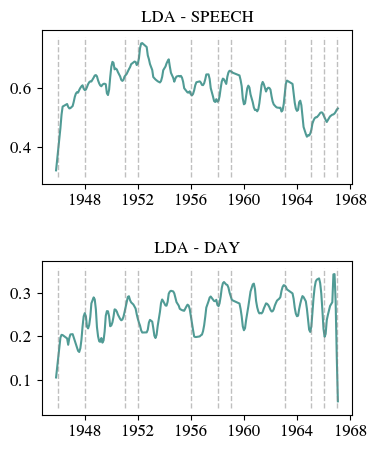

In [8]:
fig,axs = plt.subplots(2,1,figsize=(4,5))

for c,(model_type,agg_level) in enumerate(model_types):
    ax = axs.flatten()[c]
    X = linkage_stats.index.tolist()
    Y = linkage_stats[f'm_{model_type}_{agg_level}'].tolist()
    Y = adaptive_filter(Y,span=100)
    ax.plot(X,Y,c=sns.color_palette('BrBG')[-1],alpha=.75)
    ax.set_title(f'{model_type.upper()} - {agg_level.upper()}')
    add_cabinet_periods(ax,text=False,color='grey')
plt.subplots_adjust(hspace=.5)
plt.savefig('figs/linkage-diachronic-model_type-comparison.pdf',dpi=250,bbox_inches='tight')
plt.show()

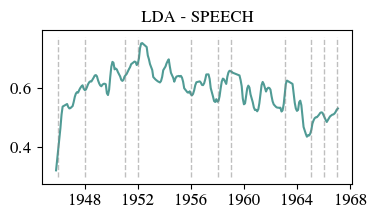

In [9]:
fig,ax = plt.subplots(1,1,figsize=(4,2))

X = linkage_stats.index.tolist()
Y = linkage_stats[f'm_lda_speech'].tolist()
Y = adaptive_filter(Y,span=100)
ax.plot(X,Y,c=sns.color_palette('BrBG')[-1],alpha=.75)
ax.set_title(f'LDA - SPEECH')
add_cabinet_periods(ax,text=False,color='grey')
plt.savefig('figs/linkage-diachronic-speech-level.pdf',dpi=250,bbox_inches='tight')
plt.show()

# Check Robustness across model K's

In [3]:
model_ks = list(range(50,451,50))

for c,k in enumerate(model_ks):
    data = dataloader.load(cf=cf,model_type='lda',agg_level='speech',num_topics=k)
    dists = data['dists']

    dict_date_theta = {d:_.to_numpy() for d,_ in dists.groupby(dists.index.to_period('M'))} # change to D here for days
    stats, mi_arrays = diachronic_linkage(dict_date_theta)
    stats = pd.DataFrame(stats)
    stats['date'] = pd.to_datetime(stats.date.dt.to_timestamp(),infer_datetime_format=True)
    if c == 0:
        linkage_stats = pd.DataFrame(index=stats.date)
    linkage_stats[f'm_{k}'] = stats['m'].tolist()

100%|██████████| 218/218 [00:47<00:00,  4.57it/s]


In [4]:
linkage_stats

,m_50,m_100,m_150,m_200,m_250,m_300,m_350,m_400,m_450
date,,,,,,,,,
1945-11-01,0.583489,0.126540,0.615676,0.611704,0.534427,0.562653,0.152451,0.342840,0.623621
1945-12-01,0.415153,0.448871,0.465788,0.575452,0.555131,0.614000,0.648955,0.637867,0.758499
1946-01-01,0.374045,0.423089,0.458323,0.532611,0.553375,0.573160,0.618235,0.596448,0.646831
1946-02-01,0.424455,0.476436,0.588233,0.689639,0.711042,0.729796,0.789741,0.816897,0.905353
1946-03-01,0.458072,0.609835,0.763922,0.955866,0.994329,1.037024,1.056782,1.137416,1.201769
...,...,...,...,...,...,...,...,...,...
1966-10-01,0.417286,0.437295,0.463726,0.503153,0.499220,0.531413,0.558481,0.592928,0.578005
1966-11-01,0.545032,0.714209,0.716066,0.850252,0.884551,0.935390,0.969244,1.035187,1.026388
1966-12-01,0.458331,0.495601,0.499324,0.506941,0.512270,0.531668,0.545112,0.539514,0.556174


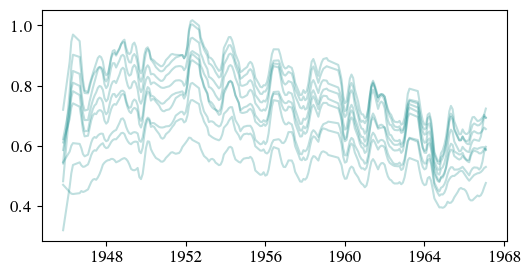

In [9]:
fig,ax = plt.subplots(1,1,figsize=(6,3))

X = linkage_stats.index.tolist()

for k in model_ks:
    Y = linkage_stats[f'm_{k}'].tolist()
    Y = adaptive_filter(Y,span=100)
    ax.plot(X,Y,label=k,color='teal',alpha=.25)